# Localization of body parts for the RWTH-Boston104 dataset with CNNs

Using Keras and TF

Prerequisites:
* Clone https://github.com/facundoq/datasets to get the code to read the dataset
* Open the script "boston104 visualize" from that repo 
* Download the dataset as instructed, split it.
* Run the script to check that the data was downloaded and can be read
* You need the "sign" folder from that repo in the python path; edit the "sys.path.append()" line below 


In [1]:
%load_ext autoreload 
%autoreload 2
import sys
sys.path.append("/data/dev/datasets/sign")

import os

basepath='/media/data/datasets/sign/rwth-boston-104'
basepath='/home/facundo/datasets/rwth-boston-104'
basepath='/data/datasets/rwth-boston-104'


import numpy as np
import tensorflow as tf
from keras import backend as K
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################


/data/dev/experiments/.env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
import boston104iterator
import target

body_parts=['head','right_hand','left_hand']

localization_grid_shape=(12,16)
localization_target=target.LocalizationTargetGrid(localization_grid_shape,body_parts)

# max_distance=20
# localization_target=target.LocalizationTargetRegression(max_distance,body_parts)

print("Loading train dataset..")
video_positions_filepath=os.path.join(basepath,'handpositions/train.xml')
batch_size=32
train_iterator=boston104iterator.Boston104LocalizationIterator(basepath,video_positions_filepath,localization_target,batch_size=batch_size,shuffle=True)

print("Loading test dataset..")
test_video_positions_filepath=os.path.join(basepath,'handpositions/test.xml')
test_iterator=boston104iterator.Boston104LocalizationIterator(basepath,test_video_positions_filepath,localization_target,batch_size=batch_size,shuffle=True)

input_shape=(train_iterator.h,train_iterator.w,1)
classes = localization_target.dims()
print("Input shape %s" % str(input_shape))
print("Classes %s" % str(classes))


Loading train dataset..
Loaded 12422 frames. 
After filtering out of bounds positions, we have 11137 frames remaining. 
Loading test dataset..
Loaded 3324 frames. 
After filtering out of bounds positions, we have 3320 frames remaining. 
Input shape (240, 316, 1)
Classes 576


TypeError: object of type 'numpy.int64' has no len()

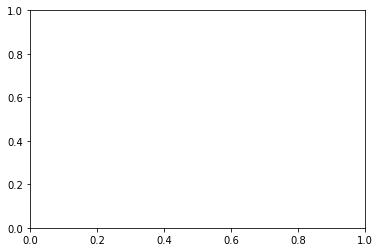

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

import matplotlib.patches as patches
import utils

def draw_coordinates(image_index,body_parts_coordinates_true,body_parts_coordinates_predicted=None,ax=plt.gca()):
    #image_index=0
    body_parts_colors_true={'head':'#ff0000','left_hand':'#00ff00','right_hand':'#0000ff'}     
    body_parts_colors_predicted={'head':'#550000','left_hand':'#005500','right_hand':'#000055'}     
    for bp in body_parts_coordinates_true.keys():
            true_coordinates=body_parts_coordinates_true[bp]
            draw_square(true_coordinates[image_index,:],color=body_parts_colors_true[bp],ax=ax)
            if (body_parts_coordinates_predicted):
                coordinates=body_parts_coordinates_predicted[bp]
                draw_squarequare(coordinates[image_index,:],color=body_parts_colors_predicted[bp],ax=ax)
    
def draw_square(position,size=15,color='#eeefff',center=False,ax=plt.gca()):
    
    size_x,size_y=(size,size)
    if center:
        position_reversed=(position[1]-size_y/2,position[0]-size_x/2)
    else:
        position_reversed=(position[1],position[0])
    rectangle=patches.Rectangle(position_reversed, size_x,size_y, fill=True,color=color)
    ax.add_patch(rectangle)

#iterator.image_position_to_grid_position(np.array([12,16]),np.array([240,316]),np.array([239,315]))
    
batch_x,batch_y=train_iterator.next()
# print(batch_y)
body_parts_coordinates=localization_target.predictions_to_body_parts_coordinates(batch_y,input_shape[0:2])

true_coordinates=localization_target.predictions_to_body_parts_coordinates(batch_y,input_shape[0:2])

image_index=0
# print(true_coordinates[image_index,:])
# print(body_parts_coordinates[body_parts[0]][image_index,:])
image=np.copy(batch_x[image_index,:,:,0])
# utils.draw_positions(image,{'head':true_coordinates[image_index,:].astype(int)})
plt.imshow(image)
draw_coordinates(image_index,true_coordinates)

plt.show()


In [4]:
import models

#model=models.resnext(input_shape,classes)
model=models.simple_conv(input_shape,classes)
#model=models.conv_mask(input_shape,classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 316, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 158, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 158, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 158, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 120, 158, 32)      128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 79, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 60, 79, 32)        128       
__________

In [5]:
from keras import optimizers

optimizer='rmsprop'
#optimizer= optimizers.SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer,
              loss=localization_target.loss,#'categorical_crossentropy',
              metrics=[localization_target.metric])

history=model.fit_generator(train_iterator,steps_per_epoch=100, epochs=10)



Epoch 1/10
100/100 [==============================] - 33s 325ms/step - loss: 3.5001 - metric: 0.1885
Epoch 2/10
100/100 [==============================] - 33s 329ms/step - loss: 3.0560 - metric: 0.3797
Epoch 3/10
100/100 [==============================] - 33s 334ms/step - loss: 2.9727 - metric: 0.4616
Epoch 4/10
100/100 [==============================] - 21s 208ms/step - loss: 2.9323 - metric: 0.5539
Epoch 5/10
100/100 [==============================] - 11s 112ms/step - loss: 2.9156 - metric: 0.6591
Epoch 6/10
100/100 [==============================] - 11s 113ms/step - loss: 2.8967 - metric: 0.7077
Epoch 7/10
100/100 [==============================] - 11s 112ms/step - loss: 2.8944 - metric: 0.7273
Epoch 8/10
100/100 [==============================] - 11s 113ms/step - loss: 2.8751 - metric: 0.7777
Epoch 9/10
100/100 [==============================] - 11s 113ms/step - loss: 2.8758 - metric: 0.7810
Epoch 10/10
100/100 [==============================] - 11s 113ms/step - loss: 2.8709 - metr

In [ ]:
print(model.metrics_names)

train_iterator.reset()
test_iterator.reset()
print("train loss, accuracy", model.evaluate_generator(train_iterator,steps=iterator.n//iterator.batch_size+1))
print("test loss, accuracy", model.evaluate_generator(test_iterator,steps=test_iterator.n//test_iterator.batch_size+1))


In [ ]:
xb,yb=iterator.next()
predictions = model.predict(xb, batch_size=batch_size)

    

body_parts_coordinates=localization_target.predictions_to_body_parts_coordinates(predictions,input_shape[0:2])
body_parts_true_coordinates=localization_target.predictions_to_body_parts_coordinates(yb,input_shape[0:2])
for bp in localization_grid_target.body_parts:
    print("Body part: %s" % bp)
    true_coordinates=body_parts_true_coordinates[bp]
    coordinates=body_parts_coordinates[bp]
    print(coordinates[:18:2,:].T)
# print(yb)


In [ ]:
            
batches=2

for batch in range(batches):
    xb,yb=test_iterator.next()
    predictions = model.predict(xb)
    body_parts_coordinates_predicted=localization_target.predictions_to_body_parts_coordinates(predictions,input_shape[0:2])
    body_parts_coordinates_true=localization_target.predictions_to_body_parts_coordinates(yb,input_shape[0:2])
    
    
    batch_size=xb.shape[0]
    for image_index in range(batch_size):
#     image_index+=1 % batch_size
#     image_index=image_index % batch_size
    #print(xb.shape, " ->", )
        plt.imshow(xb[image_index,:,:,0])
        plt.title("%d / %d" % (image_index,batch_size))
        ax=plt.gca()
        draw_coordinates(image_index,body_parts_coordinates_true,body_parts_coordinates_predicted,ax=ax)
            
        plt.show()

In [ ]:
plt.close("all")
plt.tight_layout()
i=0
plt.figure()
batches=test_iterator.n // batch_size
while i<4:#batches:
    xb,yb=test_iterator.next()
    predictions = model.predict(xb)
    body_parts_coordinates_predicted=localization_target.predictions_to_body_parts_coordinates(predictions,input_shape[0:2])
    body_parts_coordinates_true=localization_target.predictions_to_body_parts_coordinates(yb,input_shape[0:2])
    
    batch_size=xb.shape[0]
    f,axes = plt.subplots(8, 8,figsize=(20,10))
    for image_index in range(batch_size):
        subplot_i=image_index // 8
        subplot_j= image_index % 8
        ax=axes[subplot_i,subplot_j]
        ax.imshow(xb[image_index,:,:,0])
        draw_coordinates(image_index,body_parts_coordinates_true,body_parts_coordinates_predicted,ax=ax)
        ax.axis('off')
    plt.savefig("tmp/output/%06d.png" % i, bbox_inches='tight',dpi=200)
#     plt.show()

    plt.close()
    i=i+1

